<a href="https://colab.research.google.com/github/SwaRad69/quantumdiving/blob/main/VQCtest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab cell (Code)
!pip install --quiet pennylane pennylane-qiskit scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB

In [ ]:
# Colab cell (Code)
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

print("PennyLane version:", qml.__version__)


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


PennyLane version: 0.43.1


In [ ]:
# Colab cell (Code)
# Config
random_state = 42
n_samples = 300
test_size = 0.3

# Data: non-linear moons
X, y = make_moons(n_samples=n_samples, noise=0.15, random_state=random_state)

# Standardize (helps training)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (210, 2) Test shape: (90, 2)


In [ ]:
# Colab cell (Code)
clf = LogisticRegression().fit(X_train, y_train)
acc_logreg = clf.score(X_test, y_test)
print(f"Logistic Regression accuracy (test): {acc_logreg:.3f}")


Logistic Regression accuracy (test): 0.900


In [ ]:
# Colab cell (Code)
n_qubits = 2
n_layers = 2   # variational layers
n_params = n_layers * n_qubits

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(x, params):
    # Angle encoding
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)

    # Variational layers: per-qubit RY + simple entangling
    idx = 0
    for _ in range(n_layers):
        for q in range(n_qubits):
            qml.RY(params[idx], wires=q)
            idx += 1
        qml.CNOT(wires=[0, 1])

    return qml.expval(qml.PauliZ(0))

def vqc_predict_proba(X, params):
    out = np.array([circuit(x, params) for x in X])
    return (out + 1.0) / 2.0  # map [-1,1] -> [0,1]


In [ ]:
# Colab cell (Code)
params = np.random.uniform(low=-np.pi, high=np.pi, size=n_params)
probs_vqc = vqc_predict_proba(X_test, params)
preds_vqc = (probs_vqc > 0.5).astype(int)
acc_vqc = np.mean(preds_vqc == y_test)
print(f"VQC accuracy (test): {acc_vqc:.3f}")

VQC accuracy (test): 0.178


NameError: name 'train_losses' is not defined

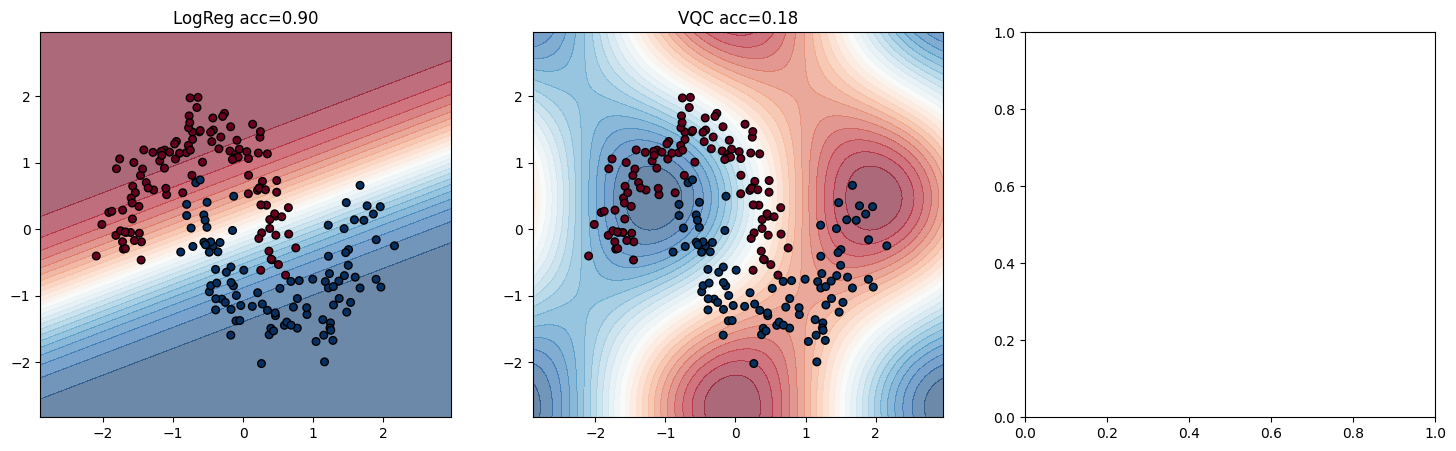

In [ ]:
# Colab cell (Code)
def plot_decision_boundary(ax, predict_fn, title):
    x_min, x_max = X[:,0].min() - 0.8, X[:,0].max() + 0.8
    y_min, y_max = X[:,1].min() - 0.8, X[:,1].max() + 0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = predict_fn(grid).reshape(xx.shape)
    ax.contourf(xx, yy, zz, levels=25, cmap="RdBu", alpha=0.6)
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolor='k', s=30, cmap="RdBu")
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

fig, axes = plt.subplots(1, 3, figsize=(18,5))

plot_decision_boundary(axes[0], lambda g: clf.predict_proba(g)[:,1], f"LogReg acc={acc_logreg:.2f}")
plot_decision_boundary(axes[1], lambda g: vqc_predict_proba(g, params), f"VQC acc={acc_vqc:.2f}")

# loss curve
axes[2].plot(np.arange(1, len(train_losses)+1) * 10, train_losses, label="train loss")
axes[2].plot(np.arange(1, len(test_losses)+1) * 10, test_losses, label="test loss")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("MSE loss")
axes[2].legend()
axes[2].set_title("VQC Loss (sampled every 10 epochs)")

plt.tight_layout()
plt.show()
